# data cleaning

In [1]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer,  TfidfTransformer
import jieba
from pycantonese.word_segmentation import Segmenter
import pycantonese
import pandas as pd
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pickle
import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_msg_valid = pd.read_excel('../../data/good_bad_somewhat_chat_history.xlsx')

In [3]:
df_pp_count = df_msg_valid.drop_duplicates(subset=['conversationId'])[['conversationId', 'max_pp']]
df_pp_count_des = df_pp_count.describe()

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Microsoft JhengHei']

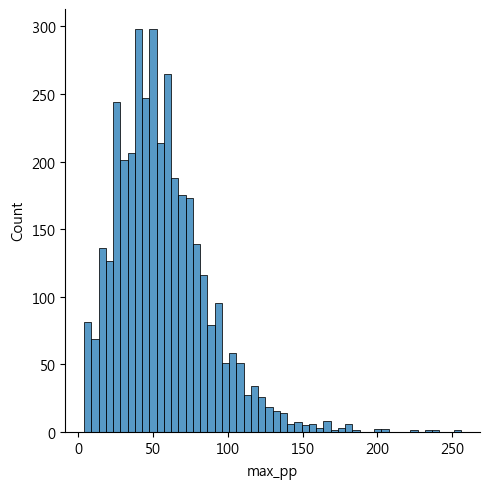

In [5]:
sns.displot(df_pp_count, x='max_pp')

In [6]:
# calculate Interquantile Range
print(df_pp_count_des.loc['75%','max_pp']+1.5*(df_pp_count_des.loc['75%','max_pp']-df_pp_count_des.loc['25%','max_pp']))

129.0


In [7]:
#select sessions with message count larger than 4 to ensure data balance
valid_convId_pp = df_pp_count[(df_pp_count['max_pp']>=4)&(df_pp_count['max_pp']<=129)]['conversationId'].tolist()
len(valid_convId_pp)

3615

In [9]:
df_pp = df_msg_valid[(df_msg_valid['conversationId'].isin(valid_convId_pp))].drop_duplicates(subset=['conversationId'])

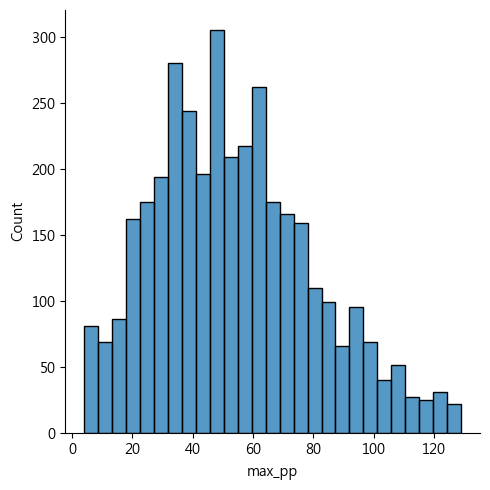

In [10]:
sns.displot(df_pp, x='max_pp')

In [11]:
df_msg_validd = df_msg_valid[(df_msg_valid['conversationId'].isin(valid_convId_pp))]
df_msg_validd.reset_index(inplace=True, drop=True)

In [12]:
good_bad_count = df_msg_validd.drop_duplicates(subset=['conversationId'])
good_bad_count['quality'].value_counts()

good    3020
bad      595
Name: quality, dtype: int64

# data processing

In [16]:
df_msg_valid = df_msg_validd.copy()

In [17]:
df_msg_valid = df_msg_valid[(df_msg_valid['conversationId'].isin(good_bad_count[(good_bad_count['quality'] == 'good')]['conversationId'].tolist()))]
df_msg_valid.reset_index(inplace=True, drop=True)

In [19]:
df_msg_valid['msg_token_list'] = None
for i in range(len(df_msg_valid['msg_token'])):
    df_msg_valid['msg_token_list'][i] = df_msg_valid['msg_token'][i].split(' ')

In [20]:
df_msg_valid=df_msg_valid.assign(pp_percentage=df_msg_valid['pp']/df_msg_valid['max_pp'])

In [21]:
# split session into equal fifth
def df_label_category(df, cat):
    labels = np.arange(len(cat)-1)
    category = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    df['pp_category'] = pd.cut(df['pp_percentage'], labels=labels, bins=category, include_lowest=True)
    return df

n_stage=6
df_msg_valid=df_msg_valid.pipe(df_label_category, np.linspace(0, 1 , n_stage) )

In [22]:
df_msg_valid['msg_token_list'] = None
for i in range(len(df_msg_valid['msg_token'])):
    df_msg_valid['msg_token_list'][i] = df_msg_valid['msg_token'][i].split(' ')

In [23]:
df_msg_valid = df_msg_valid[['conversationId', 'from_whom', 'datetime', 'msg_replace', 'msg_token', 'msg_token_list', 'pp', 'max_pp', 'pp_percentage', 'pp_category']]

In [24]:
for i in range(len(df_msg_valid['msg_token_list'])):
    if df_msg_valid['from_whom'][i] == True:
        for j in range(len(df_msg_valid['msg_token_list'][i])):
            df_msg_valid['msg_token_list'][i][j] = 'H' + df_msg_valid['msg_token_list'][i][j]
    else:
        for j in range(len(df_msg_valid['msg_token_list'][i])):
            df_msg_valid['msg_token_list'][i][j] = 'C' + df_msg_valid['msg_token_list'][i][j]

In [25]:
df_msg_valid['msg_token'] = [' '.join(i) for i in df_msg_valid['msg_token_list']]

In [26]:
df_msg_valid['pp_category'] = df_msg_valid['pp_category'].fillna(0)

# hmm training

## message-based tf-idf

In [27]:
# Instantiate TfidfVectorizer with custom stopwords
tfidf_vectorizer = TfidfVectorizer(token_pattern='\\b\\w+\\b', min_df=2)

# Fit and transform the data
tfidf_matrix = tfidf_vectorizer.fit_transform(df_msg_valid['msg_token'])

# Get feature names and their corresponding TF-IDF scores
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = np.asarray(tfidf_matrix.sum(axis=0)).flatten()

# Create a DataFrame for TF-IDF scores
tfidf_df = pd.DataFrame({'word': feature_names, 'score': tfidf_scores})

In [28]:
tfidf_df['score'].describe()

count    29170.000000
mean        13.634451
std         58.476113
min          0.099001
25%          1.436776
50%          2.524794
75%          6.656495
max       2369.742349
Name: score, dtype: float64

In [29]:
# Filter based on a score threshold (3rd quantile)
threshold = tfidf_df['score'].describe()['75%']

low_tfidf_words = list(tfidf_df.loc[tfidf_df['score']<threshold]['word'])

In [30]:
cv = CountVectorizer(min_df = 2, max_df = 1.0, token_pattern ='\\b\\w+\\b', stop_words = low_tfidf_words) #+list(low_freq_words)
cv.fit(df_msg_valid['msg_token'])
X = cv.transform(df_msg_valid['msg_token'])

In [31]:
X

<242142x7293 sparse matrix of type '<class 'numpy.int64'>'
	with 702209 stored elements in Compressed Sparse Row format>

## remove messages with no bags-of-words

In [32]:
for i in range(21):
    print("%s out of %s BoW counts has greater than %s occurence"%((X.sum(axis=1)>i).sum(axis=0)[0,0], X.shape[0],i))

231420 out of 242142 BoW counts has greater than 0 occurence
160653 out of 242142 BoW counts has greater than 1 occurence
105558 out of 242142 BoW counts has greater than 2 occurence
68928 out of 242142 BoW counts has greater than 3 occurence
44976 out of 242142 BoW counts has greater than 4 occurence
30381 out of 242142 BoW counts has greater than 5 occurence
21009 out of 242142 BoW counts has greater than 6 occurence
14820 out of 242142 BoW counts has greater than 7 occurence
10617 out of 242142 BoW counts has greater than 8 occurence
7775 out of 242142 BoW counts has greater than 9 occurence
5623 out of 242142 BoW counts has greater than 10 occurence
4236 out of 242142 BoW counts has greater than 11 occurence
3243 out of 242142 BoW counts has greater than 12 occurence
2471 out of 242142 BoW counts has greater than 13 occurence
1929 out of 242142 BoW counts has greater than 14 occurence
1546 out of 242142 BoW counts has greater than 15 occurence
1265 out of 242142 BoW counts has grea

In [33]:
## Remove conversation without any BoW inside
threshold = 1
X_final = X[np.where(X.sum(axis=1) > threshold)[0],:]
df_msg_valid_final = df_msg_valid.iloc[np.where(X.sum(axis=1) > threshold)[0],:]
df_msg_valid_final.reset_index(inplace = True, drop = True)

In [34]:
X_final

<160653x7293 sparse matrix of type '<class 'numpy.int64'>'
	with 631442 stored elements in Compressed Sparse Row format>

In [35]:
final_conv_msg_count = pd.DataFrame(df_msg_valid_final['conversationId'].value_counts())
final_conv_msg_count.reset_index(inplace=True,drop=False)

# prepare emission probability matrix

In [36]:
emission=pd.DataFrame(X_final.toarray())
df_msg_valid_final.pp_category=df_msg_valid_final.pp_category.astype(int)
emission["stage"]=df_msg_valid_final.pp_category

In [37]:
emission=emission.groupby('stage').sum()

In [38]:
emission+=1

In [39]:
emission

,0,1,2,3,4,5,6,7,8,9,...,7283,7284,7285,7286,7287,7288,7289,7290,7291,7292
stage,,,,,,,,,,,,,,,,,,,,,
0,23,4,6,39,36,8,1,4,2,1,...,37,4,5,33,3,3,1,13,19,7
1,28,3,6,58,80,11,2,5,2,1,...,8,9,9,29,7,1,4,21,30,5
2,28,5,7,60,56,10,3,5,6,1,...,11,4,11,29,3,6,2,10,28,7
3,20,4,8,87,55,18,4,3,4,2,...,5,3,9,25,2,2,1,9,29,7
4,22,10,4,59,73,33,8,3,6,18,...,4,4,8,16,1,1,2,4,32,3


# training HMM

In [40]:
import hmmlearn as hmmlearn
from hmmlearn import hmm
from hmmlearn.base import ConvergenceMonitor

In [51]:
df_emission_scale=emission.apply(lambda x:x/emission.sum(axis=1),axis=0)

## 5 stage HMM
chmm=hmmlearn.hmm.PoissonHMM(n_components=5,params ='tl', init_params='', n_iter=1000, implementation ='log' ,transmat_prior=10, lambdas_prior=10)
chmm.startprob_=np.array([1, 0, 0, 0, 0])

chmm.transmat_ = np.array([[0.55 , 0.254, 0.114, 0.074, 0.008],
                            [0.002, 0.414, 0.5  , 0.075, 0.009],
                            [0.002, 0.352, 0.394, 0.232, 0.02 ],
                            [0.   , 0.088, 0.39 , 0.392, 0.13 ],
                            [0.   , 0.   , 0.   , 0.   , 1.   ]])

chmm.lambdas_=df_emission_scale

# with open("../models/poisson4stagehmm.pkl", "rb") as file: chmm=pickle.load(file)

In [52]:
df_len=df_msg_valid_final.groupby("conversationId").count()['pp_category']

In [53]:
np.round(chmm.transmat_, 3)

array([[0.55 , 0.254, 0.114, 0.074, 0.008],
       [0.002, 0.414, 0.5  , 0.075, 0.009],
       [0.002, 0.352, 0.394, 0.232, 0.02 ],
       [0.   , 0.088, 0.39 , 0.392, 0.13 ],
       [0.   , 0.   , 0.   , 0.   , 1.   ]])

In [120]:
chmm.fit(X_final.toarray(), df_len)

PoissonHMM(init_params='', lambdas_prior=10, n_components=5, n_iter=1000,
           params='tl', random_state=RandomState(MT19937) at 0x19468755940,
           transmat_prior=10)

In [121]:
chmm.monitor_

ConvergenceMonitor(
    history=[-4280998.489512599, -3642811.0556770638, -3561356.884522278, -3544054.5620864453, -3539990.662093898, -3537401.46993812, -3535097.5766979917, -3533060.768185612, -3531639.4566856935, -3530593.7152021504, -3529785.6760704485, -3529107.4844422545, -3528473.7156679737, -3528091.9964006823, -3527842.2688646256, -3527652.3521094383, -3527497.7050889083, -3527363.1842361023, -3527252.080824137, -3527112.277208641, -3527031.9582720245, -3526956.135868515, -3526878.8078360977, -3526812.127811963, -3526747.4558993606, -3526680.191401395, -3526615.554923118, -3526557.0513532767, -3526502.5176515346, -3526452.1086594076, -3526405.239206636, -3526360.2559531946, -3526316.0926229116, -3526271.141420437, -3526222.8077991917, -3526173.555412466, -3526126.2613442126, -3526080.0133116813, -3526034.578228591, -3525989.3649476566, -3525942.619041527, -3525893.7696066955, -3525839.20823066, -3525769.5347124594, -3525691.235270884, -3525628.5947641497, -3525577.9507456296, 

In [44]:
boW_prob = pd.DataFrame(chmm.lambdas_, columns=cv.get_feature_names_out()).transpose()

In [45]:
boW_prob_baseline=pd.DataFrame(df_emission_scale.to_numpy(),columns=cv.get_feature_names_out()).transpose()

In [127]:
np.set_printoptions(suppress=True, precision=4)
np.round(chmm.transmat_, 4)

array([[0.2728, 0.4567, 0.2345, 0.0341, 0.0018],
       [0.02  , 0.4837, 0.454 , 0.0419, 0.0004],
       [0.052 , 0.4887, 0.4284, 0.0305, 0.0005],
       [0.    , 0.3558, 0.1969, 0.4382, 0.0091],
       [0.    , 0.    , 0.    , 0.    , 1.    ]])

# stage time allocation percentage

In [128]:
lengths = df_len.tolist()
chmm_pred_list = []

start = 0
for length in lengths:
    end = start + length
    subseq = X_final.toarray()[start:end]
    chmm_pred_list.append(chmm.predict(subseq, length))
    start = end
    
combined_pred_list = [item for sublist in chmm_pred_list for item in sublist]
df_msg_valid_final['pred_stage'] = combined_pred_list

In [130]:
# sort conversations by ID and time. Then calculate time duration between each message
df_msg_valid_final['time_diff'] = df_msg_valid_final.sort_values(by=['conversationId', 'datetime']).groupby('conversationId')['datetime'].diff().shift(-1)

# convert time duration to seconds
df_msg_valid_final['time_diff_seconds'] = df_msg_valid_final['time_diff'].dt.total_seconds()

# sum up time duration of each stage within each conversation
stage_durations = df_msg_valid_final.groupby(['conversationId', 'pred_stage'])['time_diff_seconds'].sum().reset_index()

# calculate total time duration of each conversation
total_durations = df_msg_valid_final.groupby('conversationId')['time_diff_seconds'].sum().reset_index()

# merge conversation total time duration to dataframe
stage_durations = stage_durations.merge(total_durations, on='conversationId')

# calculate percentage of each stage within each conversation
stage_durations['percentage'] = (stage_durations['time_diff_seconds_x'] / stage_durations['time_diff_seconds_y']) * 100

stage_durations

,conversationId,pred_stage,time_diff_seconds_x,time_diff_seconds_y,percentage
0,000000c7-0b79-4a6f-aecd-895fb97aaca7,0,230.920,1654.547,13.956690
1,000000c7-0b79-4a6f-aecd-895fb97aaca7,1,446.486,1654.547,26.985392
2,000000c7-0b79-4a6f-aecd-895fb97aaca7,2,775.612,1654.547,46.877605
3,000000c7-0b79-4a6f-aecd-895fb97aaca7,3,201.529,1654.547,12.180313
4,00062144-d067-49e6-b674-5af3b9aadfd9,1,957.540,1845.222,51.892943
...,...,...,...,...,...
10339,ffd2d0ef-d863-4d8a-a532-23be48765f6c,2,2095.327,3462.671,60.511871
10340,ffd2d0ef-d863-4d8a-a532-23be48765f6c,3,480.256,3462.671,13.869524
10341,ffdc786a-f945-4565-a91b-06994285d88e,0,429.105,3769.982,11.382150
10342,ffdc786a-f945-4565-a91b-06994285d88e,1,1157.971,3769.982,30.715558


In [50]:
# Step 1: Group by 'pred_stage' and sum the 'time_diff_seconds_x' for each stage
stage_time_sum = stage_durations.groupby('pred_stage')['time_diff_seconds_x'].sum()

# Step 2: Calculate the total time across all stages
total_time = stage_time_sum.sum()

# Step 3: Calculate the percentage for each stage across all sessions
stage_percentage = (stage_time_sum / total_time) * 100

# Step 4: Display the result
np.round(stage_percentage.tolist(), 2)

array([5.84, 38.36, 41.74, 19.82,  5.91])


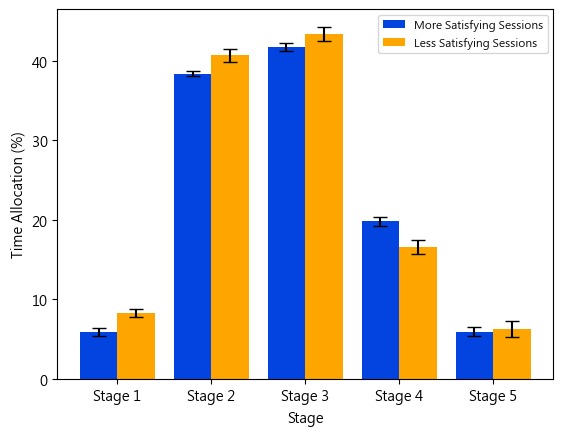

In [115]:
# Step 3: Plot the bar plot with error bars
fig, ax = plt.subplots()

x = np.arange(5)  # X positions for the stages

good = [5.84, 38.36, 41.74, 19.82,  5.91]
bad = [ 8.32, 40.72, 43.43, 16.57,  6.29]

# Plot bars with error bars
ax.bar(x - 0.2, good, 0.4, yerr=[0.54, 0.31, 0.56, 0.55, 0.53], color='#0343DF', capsize=5, label='More Satisfying Sessions')
ax.bar(x + 0.2, bad, 0.4, yerr=[0.5 , 0.82, 0.87, 0.9, 1.03 ], color='orange', capsize=5, label='Less Satisfying Sessions')

# Add labels and title
ax.set_xticks(x)
ax.set_xticklabels(['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4', 'Stage 5'])
ax.set_xlabel('Stage')
ax.set_ylabel('Time Allocation (%)')
# ax.set_title('Time Allocation by Stage (with Standard Error)')
ax.legend(fontsize=8, loc="upper right")

plt.show()